In [22]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.optim as optim


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
bb_df = pd.read_csv("/home/rb/anaconda2/bin/Project/train_boxes.csv")

In [4]:
bb_df.head()

,image_filename,x0,y0,x1,y1,label,confidence
0,frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...,601.600000,270.355731,726.755556,421.185771,van,1.0
1,frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...,497.777778,308.774704,534.755556,338.656126,car,1.0
2,frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...,449.422222,310.197628,509.155556,358.577075,car,1.0
3,frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...,711.111111,304.505929,786.488889,368.537549,car,1.0
4,frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...,584.533333,307.351779,647.111111,358.577075,car,1.0


In [5]:
n = 81542

bb_df['x3'] = bb_df['x1']
bb_df['y3'] = bb_df['y0']
bb_df['x4'] = bb_df['x0']
bb_df['y4'] = bb_df['y1']

cols = ['image_filename','x0','y0','x1','y1', 'x3','y3', 'x4', 'y4','label']
bb_df = bb_df[cols]


img_name = bb_df.ix[n, 0]


img_bb = bb_df.loc[bb_df.loc[:,'image_filename',] == img_name,['x0','y0','x1','y1', 'x3','y3', 'x4', 'y4']]
img_label = bb_df.loc[bb_df.loc[:,'image_filename'] == img_name,['label']]

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(img_bb.shape))
print('First 4 Landmarks: {}'.format(img_bb))
print('label' + str(img_label))

Image name: 0a4e5cb3-cc69-44ca-b55a-11eb0db6bc4a.mov-0001.jpg
Landmarks shape: (4, 8)
First 4 Landmarks:                 x0          y0           x1          y1           x3  \
81542  1099.377778  468.142292  1274.311111  624.664032  1274.311111   
81543   553.244444  429.723320   837.688889  691.541502   837.688889   
81544   457.955556  470.988142   557.511111  564.901186   557.511111   
81545    15.644444  493.754941   264.533333  712.885375   264.533333   

               y3           x4          y4  
81542  468.142292  1099.377778  624.664032  
81543  429.723320   553.244444  691.541502  
81544  470.988142   457.955556  564.901186  
81545  493.754941    15.644444  712.885375  
label      label
81542   van
81543   van
81544   car
81545   car


In [6]:
#image_var = io.imread("/home/rb/anaconda2/bin/Project/nexet_2017_1/"+str(img_name))

def show_bounding_box(image_var, img_bb):
    plt.imshow(image_var)
    for i in img_bb.index:
        plt.plot(img_bb.loc[i,['x0','x3']], img_bb.loc[i,['y0','y3']], color = "blue")
        plt.plot(img_bb.loc[i,['x1','x4']], img_bb.loc[i,['y1','y4']], color = "blue")
        plt.plot(img_bb.loc[i,['x0','x4']], img_bb.loc[i,['y0','y4']], color = "blue")
        plt.plot(img_bb.loc[i,['x1','x3']], img_bb.loc[i,['y1','y3']], color = "blue")

In [8]:
class CarsLoader(Dataset):
    
    def __init__(self, csv_file, root_dir, transform = None):
        self.bb_df = pd.read_csv(str(root_dir) + "/" + str(csv_file))
        self.bb_df['x3'] = self.bb_df['x1']
        self.bb_df['y3'] = self.bb_df['y0']
        self.bb_df['x4'] = self.bb_df['x0']
        self.bb_df['y4'] = self.bb_df['y1']
        cols = ['image_filename','x0','y0','x1','y1', 'x3','y3', 'x4', 'y4','label']
        self.bb_df = self.bb_df[cols]
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.bb_df)
    
    def __getitem__(self, idx):
        img_name = self.bb_df.ix[idx,0]
        img_loc = str(self.root_dir) + "/nexet_2017/"+ str(img_name)
        image = io.imread(img_loc)
        boundingboxes = self.bb_df.loc[self.bb_df.loc[:,'image_filename']==img_name,'x0':'y4']
        labels = self.bb_df.loc[self.bb_df.loc[:,'image_filename']==img_name,'label'].as_matrix()
        sample = {'image' : image, 'boundingboxes': boundingboxes, 'labels' : labels}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [9]:
carsdataset = CarsLoader(csv_file='train_boxes.csv', root_dir= '/home/rb/anaconda2/bin/Project')

In [40]:
carsdataset[1]['boundingboxes']

,x0,y0,x1,y1,x3,y3,x4,y4
0,601.600000,270.355731,726.755556,421.185771,726.755556,270.355731,601.600000,421.185771
1,497.777778,308.774704,534.755556,338.656126,534.755556,308.774704,497.777778,338.656126
2,449.422222,310.197628,509.155556,358.577075,509.155556,310.197628,449.422222,358.577075


In [47]:
for i, item in enumerate(trainLoader):
    if i < 5:
        print(i)
    else:
        break

RuntimeError: can't convert a given np.ndarray to a tensor - it has an invalid type. The only supported types are: double, float, int64, int32, and uint8.

In [44]:
enumerate(carsdataset)

In [20]:
carsdataset[1]['boundingboxes']

,x0,y0,x1,y1,x3,y3,x4,y4
0,601.600000,270.355731,726.755556,421.185771,726.755556,270.355731,601.600000,421.185771
1,497.777778,308.774704,534.755556,338.656126,534.755556,308.774704,497.777778,338.656126
2,449.422222,310.197628,509.155556,358.577075,509.155556,310.197628,449.422222,358.577075


In [82]:
sample = carsdataset[n]

In [77]:
sample['labels']

array(['van', 'van', 'car', 'car'], dtype=object)

0 (720, 1280, 3) (3, 8)
1 (720, 1280, 3) (3, 8)
2 (720, 1280, 3) (3, 8)
3 (720, 1280, 3) (2, 8)
4 (720, 1280, 3) (2, 8)
5 (720, 1280, 3) (4, 8)
6 (720, 1280, 3) (4, 8)
7 (720, 1280, 3) (4, 8)
8 (720, 1280, 3) (4, 8)
9 (720, 1280, 3) (2, 8)


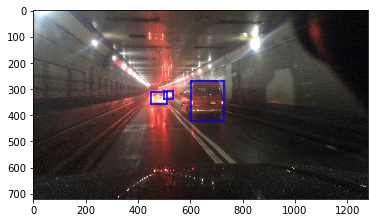

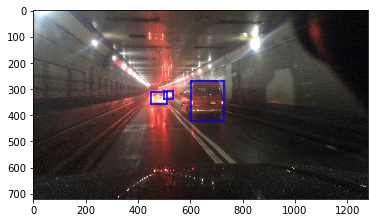

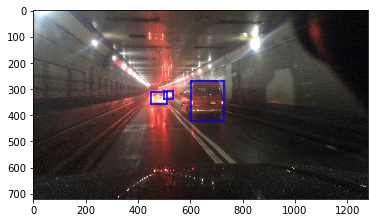

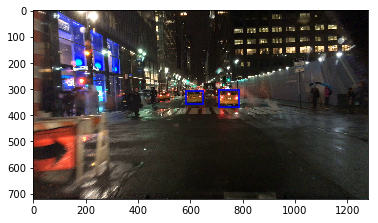

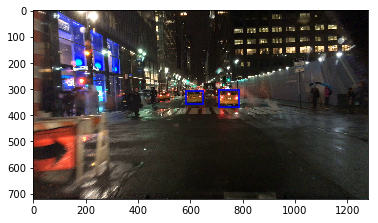

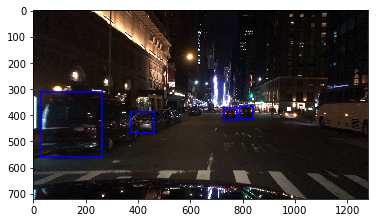

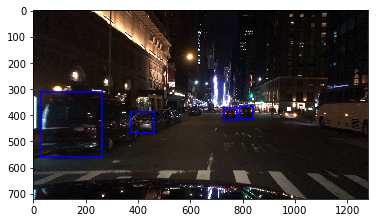

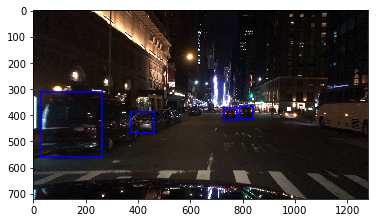

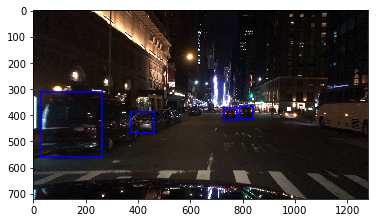

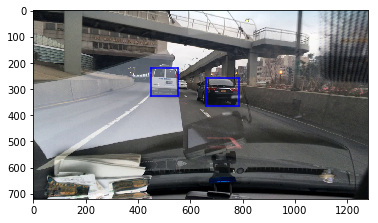

In [90]:
fig = plt.figure()

for i in range(10):
    plt.figure()
    sample = carsdataset[i]
    print(i, sample['image'].shape, sample['boundingboxes'].shape)
    show_bounding_box(sample['image'], sample['boundingboxes'])

In [30]:
from tqdm import tqdm_notebook as tqdm 

def train_model(network, criterion, optimizer, trainLoader, n_epochs = 10):
    
    iter_x = 0
    
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, items) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
        loss_df.loc[iter_x,'Type'] = "Train"
        loss_df.loc[iter_x,'Epoch'] = epoch + 1
        loss_df.loc[iter_x,'Loss'] = cum_loss / (i + 1)

        accuracy_df.loc[iter_x,'Type'] = "Train"
        accuracy_df.loc[iter_x,'Epoch'] = epoch + 1
        accuracy_df.loc[iter_x,'Accuracy'] = 100 * correct / counter

        iter_x +=1

        
        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
#         t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
#         network.eval()  # This is important to call before evaluating!
#         for (i, (inputs, labels)) in enumerate(t):

#             # Wrap inputs, and targets into torch.autograd.Variable types.
#             inputs = Variable(inputs)
#             labels = Variable(labels)

#             # Forward pass:
#             outputs = network(inputs)
#             loss = criterion(outputs, labels)

#             # logging information.
#             cum_loss += loss.data[0]
#             max_scores, max_labels = outputs.data.max(1)
#             correct += (max_labels == labels.data).sum()
#             counter += inputs.size(0)
#             t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
#             loss_df.loc[iter_x,'Type'] = "Validation"

#         loss_df.loc[iter_x,'Epoch'] = epoch + 1
#         loss_df.loc[iter_x,'Loss'] = cum_loss / (i + 1)

#         accuracy_df.loc[iter_x,'Type'] = "Validation"
#         accuracy_df.loc[iter_x,'Epoch'] = epoch + 1
#         accuracy_df.loc[iter_x,'Accuracy'] = 100 * correct / counter

#         iter_x +=1

In [23]:
trainLoader = torch.utils.data.DataLoader(carsdataset, batch_size = 64, 
                                          shuffle = True, num_workers = 0)

In [24]:
trainLoader

In [31]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 6, 5, padding = 2)
        self.conv3 = nn.Conv2d(6,12,5)
        self.conv4 = nn.Conv2d(12, 20, 3)
      
        # Linear layers.
        self.fc1 = nn.Linear(20*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv3(out))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv4(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
        
learningRate = 0.01
        
# Definition of our network.
network = LeNet()

# Criterion
criterion = nn.MSELoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate, momentum=0.8)

# Train the previously defined model.
train_model(network, criterion, optimizer, trainLoader, n_epochs = 10)                                

TypeError: 'NoneType' object has no attribute '__getitem__'